# VALIDATION

## Import libraries:

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import itertools

import sys
sys.path.append('./ML/')
from seq_utils import *
from ML_utils import *
import torch


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier


## Load data:

In [6]:
# --- Read csv file:
Data = pd.read_csv('./Data/Datasets/Boughter_Jain_Shehata_data.csv',index_col=[0])


## Load embeddings:

### PLM-based embeddings:

In [7]:
# --- Load PLM-based embeddings:
directory = './Data/Embeddings'
emb_algoritms = ['AbLang2', 'AntiBERTy', 'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S_1', 'esm2_t36_3B_UR50D', 'protbert_bfd']
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']
 
 
for emb in emb_algoritms:
    if 'esm1v' in emb:
        emb_short='esm1v'
    elif 'esm1b' in emb:
        emb_short='esm1b'
    elif 'esm2' in emb:
        emb_short='esm2'
    else:
        emb_short=emb
    try:
        for i, Ab_type in enumerate(Ab_type_list):
            mean_emd = torch.load(directory + '/' + str(emb) + '/' + 'tensor_' + str(emb) + '_' + str(Ab_type)+'.pt')
            mean_emd_list = [row.tolist() for row in mean_emd]
            col_name = str(emb_short) +'_'+ str(Ab_type)
            Data[col_name] = mean_emd_list
    except Exception as e:
        print(f"{type(e).__name__}")
        print(e)
        pass

Data.columns

ValueError
Length of values (2) does not match length of index (1523)
FileNotFoundError
[Errno 2] No such file or directory: './Data/Embeddings/esm1b_t33_650M_UR50S/tensor_esm1b_t33_650M_UR50S_VH.pt'
FileNotFoundError
[Errno 2] No such file or directory: './Data/Embeddings/esm1v_t33_650M_UR90S_1/tensor_esm1v_t33_650M_UR90S_1_VH-VL_joined.pt'
FileNotFoundError
[Errno 2] No such file or directory: './Data/Embeddings/esm2_t36_3B_UR50D/tensor_esm2_t36_3B_UR50D_VH.pt'
FileNotFoundError
[Errno 2] No such file or directory: './Data/Embeddings/protbert_bfd/tensor_protbert_bfd_VH.pt'


Index(['Name', 'Ab type', 'Dataset', 'L-CDR1', 'L-CDR2', 'L-CDR3', 'H-CDR1',
       'H-CDR2', 'H-CDR3', 'VH', 'VL', 'VH_VL_joined', 'HL-CDRs_joined',
       'H-CDRs_joined', 'L-CDRs_joined', 'react', 'PSR Score', 'AntiBERTy_VH',
       'AntiBERTy_VL', 'AntiBERTy_VH-VL_joined', 'AntiBERTy_H-CDR1',
       'AntiBERTy_H-CDR2', 'AntiBERTy_H-CDR3', 'AntiBERTy_L-CDR1',
       'AntiBERTy_L-CDR2', 'AntiBERTy_L-CDR3', 'AntiBERTy_H-CDRs_joined',
       'AntiBERTy_L-CDRs_joined', 'AntiBERTy_HL-CDRs_joined', 'esm1v_VH',
       'esm1v_VL'],
      dtype='object')

### Schrödinger descriptors:

In [8]:
# --- Load Schrödinger descriptors:
directory = './Data/Embeddings/Schrödinger_desc/Boughter_Jain_Shehata_datasets/'
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

dict_Ab_type_desc = {}
for i, Ab_type in enumerate(Ab_type_list):
    path_desc = directory + str(Ab_type) + '/sequence_descriptors.csv'
    path_seq = directory + str(Ab_type) + '/'+ Ab_type +'.fasta'
    Data_desc = pd.read_csv(path_desc,index_col=0)
    schrod_desc = list(Data_desc.columns[2:])
    
    # --- Add theoretical pI:
    seq_list = [str(rec.seq) for rec in list(SeqIO.parse(path_seq, "fasta"))]
    id_list = [rec.id for rec in list(SeqIO.parse(path_seq, "fasta"))]
    Data_desc[Ab_type] = seq_list
    Data_desc['Theoretical pI'] = [ProteinAnalysis(seq).isoelectric_point() for seq in seq_list]
    Data_desc['Dataset'] = [name.split('_')[-1] for name in list(Data_desc['Name'])]
    
    # --- Add react in df_data:
    Data_desc['react'] = list(Data['react'])
    Data_desc['PSR Score'] = list(Data['PSR Score'])
    Data_desc['Ab type'] = list(Data['Ab type'])
    
    # --- Re-arrange columns:
    Data_desc = Data_desc[sum([['Dataset','Ab type',Ab_type,'react','PSR Score','Theoretical pI'], schrod_desc],[])]
    
    # --- Make dictionary df[Ab_type]:
    dict_Ab_type_desc[Ab_type] = Data_desc

    
dict_Ab_type_desc['VH']



,Dataset,Ab type,VH,react,PSR Score,Theoretical pI,Bulkiness,Polarity_Grantham,Recognition_Factors,Hydrophobicity_Sweet,...,Aa_Composition_Swissprot,Disorder_Propensity_TOP_IDP,Aa_Flexibility_VTR,Disorder_Propensity_FoldUnfold,Disorder_Propensity_DisProt,Aggrescan_av4,Aggrescan_av4_pos,Aggrescan_Nr_hotspots,Zyggregator_profile_smoothed,Zyggregator_profile_smoothed_pos
0,Boughter,Mouse IgA,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,0,NaN,9.187148,1728.87,981.5,10668.0,3.87,...,650.47,3.427,118.485,2481.97,-3.567,2.4478,20.3812,4,-54.434863,18.604673
1,Boughter,Mouse IgA,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,0,NaN,6.300625,1671.22,1004.7,10471.0,-13.80,...,655.37,9.864,117.417,2419.57,3.220,-9.6298,17.7968,3,-46.473391,23.817941
2,Boughter,Mouse IgA,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,0,NaN,8.511519,1788.07,1014.5,10886.0,2.81,...,653.70,1.773,121.338,2552.26,-4.180,1.2068,22.9000,4,-29.928827,31.661863
3,Boughter,Mouse IgA,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,0,NaN,4.924724,1742.86,1024.4,10926.0,-2.24,...,721.74,3.851,123.343,2577.27,-1.112,0.0892,21.4620,4,-54.803625,18.268407
4,Boughter,Mouse IgA,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,0,NaN,5.386086,1701.35,1030.7,10804.0,-7.50,...,701.33,8.483,121.564,2505.29,1.470,-6.6398,20.2168,5,-51.848781,27.247647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,Shehata,NaN,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,0,0.000000,9.100438,1897.86,1098.0,11905.0,-4.04,...,766.07,7.919,132.553,2758.49,-0.768,1.8088,24.3476,3,-40.614596,31.553610
1519,Shehata,NaN,EVQLLESGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,0,0.000000,4.851572,1801.79,1056.3,11186.0,-6.54,...,734.36,8.089,126.419,2624.56,0.441,1.3932,23.9912,3,-45.711507,21.501872
1520,Shehata,NaN,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,0,0.071894,7.883661,1805.08,1007.7,11221.0,9.22,...,704.18,3.769,124.326,2616.15,-4.598,15.6178,32.0480,5,-19.712690,39.585894
1521,Shehata,NaN,EVQLVESGGGLVQPGGSLKLSCAASGFTFSGSAMHWVRQASGKGLE...,0,0.124712,8.656895,1730.12,1008.5,10750.0,-5.90,...,721.11,5.321,121.095,2533.70,-0.080,2.1112,22.4620,4,-46.804691,22.171702


## Split data and select two classes:

### PLM-based data:

In [9]:
# --- Split into separate DataFrames:
Data_Jain = Data[Data['Dataset']=='Jain']
Data_Shehata = Data[Data['Dataset']=='Shehata']
Data_Boughter = Data[Data['Dataset']=='Boughter']

Data_Jain.reset_index(drop=True, inplace=True)
Data_Shehata.reset_index(drop=True, inplace=True)
Data_Boughter.reset_index(drop=True, inplace=True)

# --- Select two classes (0,>3 flags):
# Add 'class' to Data:
Data_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_Boughter.react.values]

# --- Shuffle data:
Data_Boughter_shuffled = Data_Boughter.sample(frac=1).reset_index(drop=True)

# --- Select classes:
sub_Data_Boughter_2classes = Data_Boughter_shuffled[(Data_Boughter_shuffled['react']==0) | (Data_Boughter_shuffled['react']>3)]
sub_Data_Boughter_2classes['class'] = [0 if i ==0 else 1 for i in sub_Data_Boughter_2classes.react.values]
sub_Data_Boughter_2classes.reset_index(drop=True, inplace=True)

/tmp/ipykernel_28137/712235513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_Boughter.react.values]
/tmp/ipykernel_28137/712235513.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_Data_Boughter_2classes['class'] = [0 if i ==0 else 1 for i in sub_Data_Boughter_2classes.react.values]


### Schrödinger descriptors:

In [10]:
# --- Split into separate DataFrames:
schrod_desc = sum([['Theoretical pI'],schrod_desc],[])
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

dict_desc_Jain, dict_desc_Shehata, dict_desc_Boughter = {}, {}, {}
dict_desc_Jain_2classes, dict_desc_Boughter_2classes = {}, {}
for i, Ab_type in enumerate(Ab_type_list):
    Data_desc = dict_Ab_type_desc[Ab_type]
    
    Data_desc_Jain = Data_desc[Data_desc['Dataset']=='Jain'].copy()
    Data_desc_Shehata = Data_desc[Data_desc['Dataset']=='Shehata'].copy()
    Data_desc_Boughter = Data_desc[Data_desc['Dataset']=='Boughter'].copy()

    Data_desc_Jain.reset_index(drop=True, inplace=True)
    Data_desc_Shehata.reset_index(drop=True, inplace=True)
    Data_desc_Boughter.reset_index(drop=True, inplace=True)
    
    # Add 'class' to df:
    Data_desc_Jain['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_desc_Jain.react.values]
    Data_desc_Shehata['class'] = [0 if i<=0.33 else 1 for i in list(Data_desc_Shehata['PSR Score'])]
    Data_desc_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_desc_Boughter.react.values]
    
    Data_desc_Jain = Data_desc_Jain[sum([['Dataset','Ab type', Ab_type,'react','class'],schrod_desc],[])]
    Data_desc_Shehata = Data_desc_Shehata[sum([['Dataset','Ab type', Ab_type,'PSR Score','class'],schrod_desc],[])]
    Data_desc_Boughter = Data_desc_Boughter[sum([['Dataset','Ab type', Ab_type,'react','class'],schrod_desc],[])]
    
    dict_desc_Jain[Ab_type] = Data_desc_Jain 
    dict_desc_Shehata[Ab_type] = Data_desc_Shehata 
    dict_desc_Boughter[Ab_type] = Data_desc_Boughter
    
    # Split into two classes:
    sub_Data_desc_Jain = Data_desc_Jain[(Data_desc_Jain['react']==0) | (Data_desc_Jain['react']>3)].copy()
    sub_Data_desc_Boughter = Data_desc_Boughter[(Data_desc_Boughter['react']==0) | (Data_desc_Boughter['react']>3)].copy()

    sub_Data_desc_Jain.reset_index(drop=True, inplace=True)
    sub_Data_desc_Boughter.reset_index(drop=True, inplace=True)
    
    dict_desc_Jain_2classes[Ab_type] = sub_Data_desc_Jain 
    dict_desc_Boughter_2classes[Ab_type] = sub_Data_desc_Boughter

dict_desc_Boughter_2classes['VH']

,Dataset,Ab type,VH,react,class,Theoretical pI,Bulkiness,Polarity_Grantham,Recognition_Factors,Hydrophobicity_Sweet,...,Aa_Composition_Swissprot,Disorder_Propensity_TOP_IDP,Aa_Flexibility_VTR,Disorder_Propensity_FoldUnfold,Disorder_Propensity_DisProt,Aggrescan_av4,Aggrescan_av4_pos,Aggrescan_Nr_hotspots,Zyggregator_profile_smoothed,Zyggregator_profile_smoothed_pos
0,Boughter,Mouse IgA,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,0,0.0,9.187148,1728.87,981.5,10668.0,3.87,...,650.47,3.427,118.485,2481.97,-3.567,2.4478,20.3812,4,-54.434863,18.604673
1,Boughter,Mouse IgA,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,0,0.0,6.300625,1671.22,1004.7,10471.0,-13.80,...,655.37,9.864,117.417,2419.57,3.220,-9.6298,17.7968,3,-46.473391,23.817941
2,Boughter,Mouse IgA,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,0,0.0,8.511519,1788.07,1014.5,10886.0,2.81,...,653.70,1.773,121.338,2552.26,-4.180,1.2068,22.9000,4,-29.928827,31.661863
3,Boughter,Mouse IgA,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,0,0.0,4.924724,1742.86,1024.4,10926.0,-2.24,...,721.74,3.851,123.343,2577.27,-1.112,0.0892,21.4620,4,-54.803625,18.268407
4,Boughter,Mouse IgA,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,0,0.0,5.386086,1701.35,1030.7,10804.0,-7.50,...,701.33,8.483,121.564,2505.29,1.470,-6.6398,20.2168,5,-51.848781,27.247647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,Boughter,HIV reactive,EVQLVESGGTLVQPGGSLRLSCAGSGFTFSDHYMDWVRQAPGKGLE...,0,0.0,8.054696,1697.49,1021.2,10716.0,-11.24,...,703.52,7.432,120.425,2497.04,1.033,-8.3058,17.1374,1,-56.667548,16.400661
662,Boughter,HIV reactive,EVQLVQSGAEVRKPGESLRISCKCSGYNFDNHWIGWVRQRPGKGLE...,0,0.0,6.991673,1748.69,1029.9,10876.0,-10.77,...,683.45,8.199,121.573,2534.35,1.258,-9.5020,17.3352,2,-84.076123,15.898389
663,Boughter,HIV reactive,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,5,1.0,8.913286,1698.06,952.3,10549.0,-0.50,...,668.81,7.675,116.359,2423.68,-1.763,10.1898,26.0452,5,-20.238878,34.679592
664,Boughter,HIV reactive,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYIHWVRQAPGQGLE...,0,0.0,6.908859,1765.72,1017.4,10725.0,-0.07,...,663.38,4.855,121.212,2544.86,-0.948,-0.2024,22.2082,5,-39.819721,24.479240


## Test on Jain dataset:

### ESM 1v VH-based LogisticReg model:

ML algorithms: LogisticReg
Accuracy:  0.686046511627907


/tmp/ipykernel_26339/462702843.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Jain['class'] = [0 if i<1 else 1 for i in list(Data_Jain_full['react']) ]


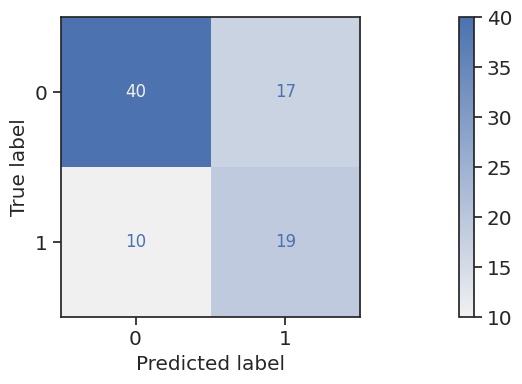

/tmp/ipykernel_26339/462702843.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Jain['class_3'] = [0 if i==0 else 1 if i>=4 else 0.5 for i in list(Data_Jain['react'])]
/tmp/ipykernel_26339/462702843.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Jain['prob class 0'] = list(clf2.predict_proba(X_test_full)[:,0])
/tmp/ipykernel_26339/462702843.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Spearman corr:  0.27408006223202974
P-value:  0.0011914307267288052
PermutationTestResult(statistic=np.float64(0.27408006223202974), pvalue=np.float64(0.0016), null_distribution=array([ 0.1405174 , -0.11526204,  0.043031  , ...,  0.07769179,
        0.06162846, -0.0277306 ], shape=(9999,)))


/tmp/ipykernel_26339/462702843.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  s = sns.catplot(x="prob",
/tmp/ipykernel_26339/462702843.py:173: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  s = sns.catplot(x="prob",
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


<Figure size 2000x400 with 0 Axes>

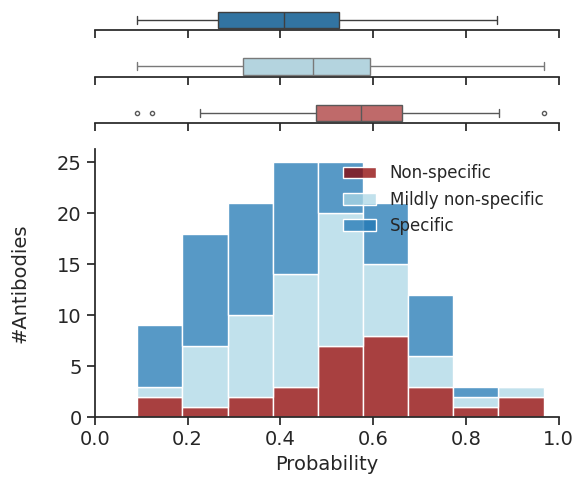

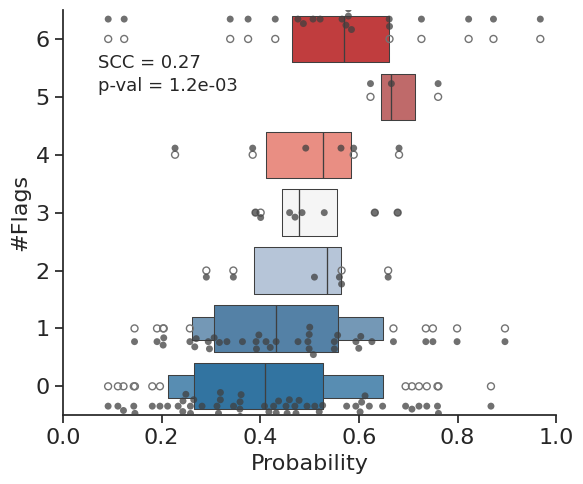

Specific vs mildly non-specific:
P-value:  0.11594
Specific vs non-specific:
P-value:  0.003176
Mildly vs non-specific:
P-value:  0.027867


In [16]:
Ab_type = 'VH'

emb = 'esm1v_VH'

model = 'LogisticReg'

emb_title = 'VH ESM 1v mean'

classifier_dict={"LogisticReg": LogisticRegression(max_iter=500)}

# --- Define Jain data:
Data_Jain_full = Data_Jain
Data_Jain['class'] = [0 if i<1 else 1 for i in list(Data_Jain_full['react']) ]
sub_Data_Jain = sub_Data_Jain[(sub_Data_Jain['react']==0) | (sub_Data_Jain['react']>3)] # Select sub-part of data, i.e. group 1 (zero flags) and 2 (>3 flags):
sub_Data_Jain['class'] = [0 if i<1 else 1 for i in list(sub_Data_Jain['react']) ]


# --- Classify:
    
# Define training/test data:
X=sub_Data_Boughter_2classes[emb].values
X_train=np.array([list(i) for i in X])
y_train=sub_Data_Boughter_2classes['class'].values

X_test = sub_Data_Jain[emb].values
X_test = np.array([list(i) for i in X_test])
y_test = sub_Data_Jain['class'].values

X_test_full = Data_Jain_full[emb].values
X_test_full = np.array([list(i) for i in X_test_full])
y_test_full = Data_Jain_full['class'].values


# Classify based on parsed dataset (exchange if gives same result - LLSH):    
clf=classifier_dict[model]
clf.fit(X_train, y_train)
score_OneSplit = clf.score(X_test, y_test)

print('ML algorithms: ' + str(model))
print('Accuracy: ', score_OneSplit)

conf_mat = confusion_matrix(y_test, clf.predict(X_test),labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=clf.classes_)
disp.plot(cmap=sns.color_palette("light:b", as_cmap=True),values_format='g')
#plt.title(str(model) + ' ' + str(emb_title[i]))
plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_conf_mat'+str(model)+'_'+str(emb) +'.pdf',dpi=300)

plt.show()


# --- Distriubution plot of probability (3 classes):
plt.figure(1)
sns.set(style='ticks') # Make white lines between bars.

# Create a subplot with row=3 and col=1, specify height ratio, and define handles for order of the plots (e.g. ax_box1,ax_box2, ax_hist):
f, (ax_box1,ax_box2,ax_box3, ax_hist) = plt.subplots(4,1,figsize=(6,5),sharex=True, gridspec_kw={'height_ratios': (0.06,0.06, 0.06, 0.80)})
 
# Define data:

# Classify based on parsed dataset:    
clf2=classifier_dict[model]
clf2.fit(X_train, y_train)

Data_Jain['class_3'] = [0 if i==0 else 1 if i>=4 else 0.5 for i in list(Data_Jain['react'])] 
Data_Jain['prob class 0'] = list(clf2.predict_proba(X_test_full)[:,0])
Data_Jain['prob class 1'] = list(clf2.predict_proba(X_test_full)[:,1])
data1 = Data_Jain[Data_Jain['react']==0]['prob class 1']
data2 = Data_Jain[(Data_Jain['react']>0) | (Data_Jain['react']<4)]['prob class 1']
data3 = Data_Jain[Data_Jain['react']>=4]['prob class 1']

# Create the plots for the respective axes (ax_box1,ax_box2, ax_hist):
sns.boxplot(data1, 
            ax=ax_box1,
            color='tab:blue',
            #saturation=0.75,
            orient="h",
            fliersize=3)

sns.boxplot(data2,
            ax=ax_box2,
            color='lightblue',
            #saturation=0.75,
            orient="h",
            fliersize=3)

sns.boxplot(data3,
            ax=ax_box3,
            color='indianred',
            #saturation=0.75,
            orient="h",
            fliersize=3)

g=sns.histplot(data=Data_Jain,
               x='prob class 1',
               hue='class_3',
               palette=['tab:blue','lightblue','darkred'],
               #bins=8,
               ax=ax_hist,
               #kde=True,
               multiple='stack',
               legend=False)
g.set(xlim=(0,1))
plt.legend(labels=['Non-specific','Mildly non-specific','Specific'],
           loc='upper right',
           prop={'size':12},
           #bbox_to_anchor=(1.2, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )
#plt.ylim(0,20)
plt.xlabel('Probability',fontsize=14)
plt.ylabel('#Antibodies',fontsize=14,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=14)

# Remove black lines and yticks of the boxplots:
ax_box1.set(yticks=[],xlabel='')
ax_box2.set(yticks=[],xlabel='')
ax_box3.set(yticks=[],xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box1,left=True, right=True)
sns.despine(ax=ax_box2,left=True, right=True)
sns.despine(ax=ax_box3,left=True, right=True)

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_dist_prob_all_Abs_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)




# --- Regression-like boxplots (all flags):
# Set fonts globally:
import matplotlib.pylab as pylab

params = {'legend.title_fontsize': 'medium',
          'legend.fontsize': 'medium',
          'figure.figsize': (20, 4),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create an array with the colors:
colors = ['tab:blue','steelblue','lightsteelblue','whitesmoke','salmon','indianred','tab:red','firebrick']

# Define df:    
df_boxplot3 = pd.DataFrame({'prob': clf.predict_proba(X_test_full)[:,1], 
                            'class': y_test_full, 
                            'react': Data_Jain['react']
                            })

# --- Spearman correlation:
from scipy import stats
#kendalltau
corr, pval = stats.spearmanr(list(df_boxplot3['react']),list(df_boxplot3['prob']))
print('Spearman corr: ', corr)
print('P-value: ', pval)

# Permutation test (for small samples):
x = list(df_boxplot3['react'])
y = list(df_boxplot3['prob'])
def permutation(x):
    corr, p = stats.spearmanr(x,y)
    return corr

result_exact = stats.permutation_test((x,), permutation, permutation_type='pairings')
print(result_exact)

plt.figure(2)
s = sns.catplot(x="prob", 
                y="react", 
                kind='boxen',
                data=df_boxplot3,
                #saturation=0.9,
                palette=colors,
                orient="h")

s.map_dataframe(sns.swarmplot,
                x="prob", 
                y="react", 
                data=df_boxplot3,
                orient='h',
                palette=["#404040"], 
                alpha=0.75,
                s=5,
                dodge=True)

for ax in s.axes[0]:
    ax.invert_yaxis()
    
plt.xlim(0,1)    
plt.text(0.07,5.5, #0.75,0.7
          'SCC = ' + str(round(corr,2)), 
          fontsize=13,
          )
plt.text(0.07,5.1,#0.75,0.66
          'p-val = '+ str('{:.1e}'.format(pval)), 
          fontsize=13,
          )

plt.ylabel('#Flags', fontsize=16)
plt.xlabel('Probability', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

s.fig.set_size_inches(6,5) #6,4

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_boxplot_all_Abs_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
plt.show()

# t-test:
'''
H0: Samples come from populations with the same population mean
H1: Samples come from population with different population mean
P-value is the probability that the H0 hypothesis is true.
'''
from scipy import stats
t_test_result_1v2 = stats.ttest_ind(list(data1),list(data2))
t_test_result_1v3 = stats.ttest_ind(list(data1),list(data3))
t_test_result_2v3 = stats.ttest_ind(list(data2),list(data3))

print('Specific vs mildly non-specific:')
pval = '{:.5}'.format(t_test_result_1v2.pvalue)
print('P-value: ', pval)

print('Specific vs non-specific:')
pval2 = '{:.5}'.format(t_test_result_1v3.pvalue)
print('P-value: ', pval2)

print('Mildly vs non-specific:')
pval3 = '{:.5}'.format(t_test_result_2v3.pvalue)
print('P-value: ', pval3)
    

### Top 5 descriptors VH-based LogisticReg model:

/tmp/ipykernel_26339/1293620169.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_Data_desc_Jain['class'] = [0 if i<1 else 1 for i in list(sub_Data_desc_Jain['react']) ]


ML algorithms: LogisticReg
Accuracy:  0.5930232558139535


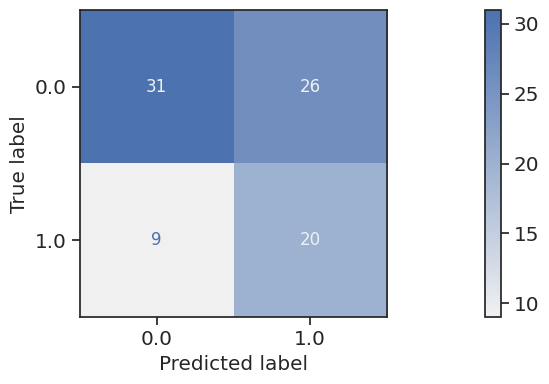

Spearman corr:  0.2488516947225718
P-value:  0.0033643938979338673
PermutationTestResult(statistic=np.float64(0.2488516947225718), pvalue=np.float64(0.0054), null_distribution=array([-0.1846793 ,  0.18388448, -0.0989215 , ..., -0.13848127,
        0.02180129,  0.00597591], shape=(9999,)))


/tmp/ipykernel_26339/1293620169.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  s = sns.catplot(x="prob",
/tmp/ipykernel_26339/1293620169.py:184: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  s = sns.catplot(x="prob",
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/llsh/.conda/envs/NSB_model/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


<Figure size 2000x400 with 0 Axes>

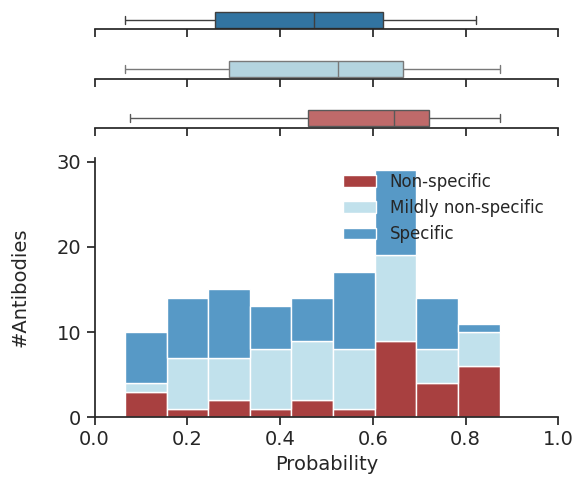

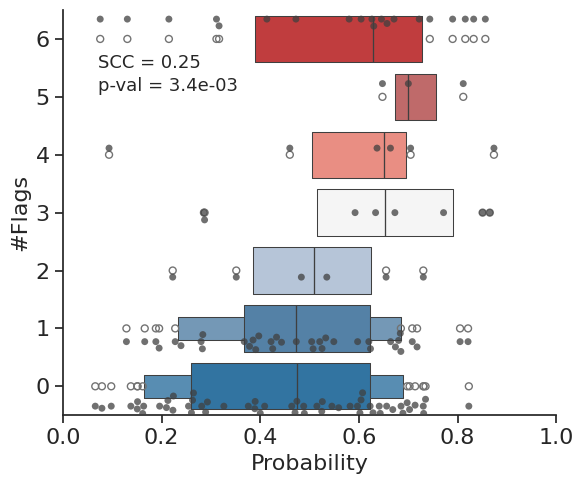

Specific vs mildly non-specific:
P-value:  0.15024
Specific vs non-specific:
P-value:  0.0094101
Mildly vs non-specific:
P-value:  0.06287


In [11]:
Ab_type = 'VH'

model = 'LogisticReg'

emb_title = ['Top 5 descriptors VH']

classifier_dict={"LogisticReg": LogisticRegression(max_iter=500)}


# --- Define Jain data:
Data_desc_Jain_full = dict_desc_Jain[Ab_type]
sub_Data_desc_Jain = Data_desc_Jain_full[(Data_desc_Jain_full['react']==0) | (Data_desc_Jain_full['react']>3)] # Select sub-part of data, i.e. group 1 (zero flags) and 2 (>3 flags):
sub_Data_desc_Jain['class'] = [0 if i<1 else 1 for i in list(sub_Data_desc_Jain['react']) ]

    
# --- Classify:
desc_top5 = ['Theoretical pI', 
             'Bulkiness', 
             'Disorder_Propensity_DisProt', 
             'Percentage_Accessible_Res', 
             'Aggrescan_av4']

desc_input = desc_top5

    
# Define training/test data:
sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
X = np.array([np.array(sub_data_2classes[desc_input])[i,:] for i in range(len(sub_data_2classes[desc_input]))]) 
scaler = StandardScaler().fit(X) # Normalize X.
X_train = scaler.transform(X) # Normalize X.
y_train=sub_data_2classes['class'].values

X_test = np.array([np.array(sub_Data_desc_Jain[desc_input])[i,:] for i in range(len(sub_Data_desc_Jain[desc_input]))]) 
scaler = StandardScaler().fit(X_test) # Normalize X.
X_test = scaler.transform(X_test) # Normalize X.
y_test =sub_Data_desc_Jain['class'].values

X_test_full = np.array([np.array(Data_desc_Jain_full[desc_input])[i,:] for i in range(len(Data_desc_Jain_full[desc_input]))])
scaler = StandardScaler().fit(X_test_full) # Normalize X.
X_test_full = scaler.transform(X_test_full) # Normalize X.
y_test_full = Data_desc_Jain_full['class'].values


# Classify based on parsed dataset:
clf=classifier_dict[model]
clf.fit(X_train, y_train)
score_OneSplit = clf.score(X_test, y_test)

print('ML algorithms: ' + str(model))
print('Accuracy: ', score_OneSplit)


conf_mat = confusion_matrix(y_test, clf.predict(X_test),labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=clf.classes_)
disp.plot(cmap=sns.color_palette("light:b", as_cmap=True),values_format='g')
#plt.title(str(model) + ' ' + str(emb_title[i]))
plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_conf_mat'+str(model)+'_'+str(emb) +'.pdf',dpi=300)

plt.show()


# --- Distriubution plot of probability (3 classes):
plt.figure(1)
sns.set(style='ticks') # Make white lines between bars.

# Create a subplot with row=3 and col=1, specify height ratio, and define handles for order of the plots (e.g. ax_box1,ax_box2, ax_hist):
f, (ax_box1,ax_box2,ax_box3, ax_hist) = plt.subplots(4,1,figsize=(6,5),sharex=True, gridspec_kw={'height_ratios': (0.06,0.06, 0.06, 0.80)})
 
# Define data:

# Classify based on parsed dataset:    
clf2=classifier_dict[model]
clf2.fit(X_train, y_train)

Data_desc_Jain['class_3'] = [0 if i==0 else 1 if i>=4 else 0.5 for i in list(Data_desc_Jain['react'])] 
Data_desc_Jain['prob class 0'] = list(clf2.predict_proba(X_test_full)[:,0])
Data_desc_Jain['prob class 1'] = list(clf2.predict_proba(X_test_full)[:,1])
data1 = Data_desc_Jain[Data_desc_Jain['react']==0]['prob class 1']
data2 = Data_desc_Jain[(Data_desc_Jain['react']>0) | (Data_desc_Jain['react']<4)]['prob class 1']
data3 = Data_desc_Jain[Data_desc_Jain['react']>=4]['prob class 1']

# Create the plots for the respective axes (ax_box1,ax_box2, ax_hist):
sns.boxplot(data1, 
            ax=ax_box1,
            color='tab:blue',
            #saturation=0.75,
            orient="h",
            fliersize=3)

sns.boxplot(data2,
            ax=ax_box2,
            color='lightblue',
            #saturation=0.75,
            orient="h",
            fliersize=3)

sns.boxplot(data3,
            ax=ax_box3,
            color='indianred',
            #saturation=0.75,
            orient="h",
            fliersize=3)

g=sns.histplot(data=Data_desc_Jain,
               x='prob class 1',
               hue='class_3',
               palette=['tab:blue','lightblue','darkred'],
               #bins=8,
               ax=ax_hist,
               #kde=True,
               multiple='stack',
               legend=False)
g.set(xlim=(0,1))
plt.legend(labels=['Non-specific','Mildly non-specific','Specific'],
           loc='upper right',
           prop={'size':12},
           #bbox_to_anchor=(1.2, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )
#plt.ylim(0,20)
plt.xlabel('Probability',fontsize=14)
plt.ylabel('#Antibodies',fontsize=14,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=14)

# Remove black lines and yticks of the boxplots:
ax_box1.set(yticks=[],xlabel='')
ax_box2.set(yticks=[],xlabel='')
ax_box3.set(yticks=[],xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box1,left=True, right=True)
sns.despine(ax=ax_box2,left=True, right=True)
sns.despine(ax=ax_box3,left=True, right=True)

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_dist_prob_all_Abs_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)




# --- Regression-like boxplots (all flags):
# Set fonts globally:
import matplotlib.pylab as pylab

params = {'legend.title_fontsize': 'medium',
          'legend.fontsize': 'medium',
          'figure.figsize': (20, 4),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create an array with the colors:
colors = ['tab:blue','steelblue','lightsteelblue','whitesmoke','salmon','indianred','tab:red','firebrick']

# Define df:    
df_boxplot3 = pd.DataFrame({'prob': clf.predict_proba(X_test_full)[:,1], 
                            'class': y_test_full, 
                            'react': Data_desc_Jain['react']
                            })
    
# --- Spearman correlation:
from scipy import stats
#kendalltau
corr, pval = stats.spearmanr(list(df_boxplot3['react']),list(df_boxplot3['prob']))
print('Spearman corr: ', corr)
print('P-value: ', pval)

# Permutation test (for small samples):
x = list(df_boxplot3['react'])
y = list(df_boxplot3['prob'])
def permutation(x):
    corr, p = stats.spearmanr(x,y)
    return corr

result_exact = stats.permutation_test((x,), permutation, permutation_type='pairings')
print(result_exact)

plt.figure(2)
s = sns.catplot(x="prob", 
                y="react", 
                kind='boxen',
                data=df_boxplot3,
                #saturation=0.9,
                palette=colors,
                orient="h")

s.map_dataframe(sns.swarmplot,
                x="prob", 
                y="react", 
                data=df_boxplot3,
                orient='h',
                palette=["#404040"], 
                alpha=0.75,
                s=5,
                dodge=True)

for ax in s.axes[0]:
    ax.invert_yaxis()
    
plt.xlim(0,1)    
plt.text(0.07,5.5, #0.75,0.7
          'SCC = ' + str(round(corr,2)), 
          fontsize=13,
          )
plt.text(0.07,5.1,#0.75,0.66
          'p-val = '+ str('{:.1e}'.format(pval)), 
          fontsize=13,
          )

plt.ylabel('#Flags', fontsize=16)
plt.xlabel('Probability', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

s.fig.set_size_inches(6,5) #6,4

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_boxplot_all_Abs_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
plt.show()

# t-test:
'''
H0: Samples come from populations with the same population mean
H1: Samples come from population with different population mean
P-value is the probability that the H0 hypothesis is true.
'''
from scipy import stats
t_test_result_1v2 = stats.ttest_ind(list(data1),list(data2))
t_test_result_1v3 = stats.ttest_ind(list(data1),list(data3))
t_test_result_2v3 = stats.ttest_ind(list(data2),list(data3))

print('Specific vs mildly non-specific:')
pval = '{:.5}'.format(t_test_result_1v2.pvalue)
print('P-value: ', pval)

print('Specific vs non-specific:')
pval2 = '{:.5}'.format(t_test_result_1v3.pvalue)
print('P-value: ', pval2)
    
print('Mildly vs non-specific:')
pval3 = '{:.5}'.format(t_test_result_2v3.pvalue)
print('P-value: ', pval3)



## Test on Shehata dataset:

### ESM 1v VH-based LogisticReg model:

/tmp/ipykernel_26339/4291320321.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Shehata['class'] = [0 if i<=0.33 else 1 for i in list(Data_Shehata['PSR Score']) ]


ML algorithms: LogisticReg
Accuracy:  0.5879396984924623


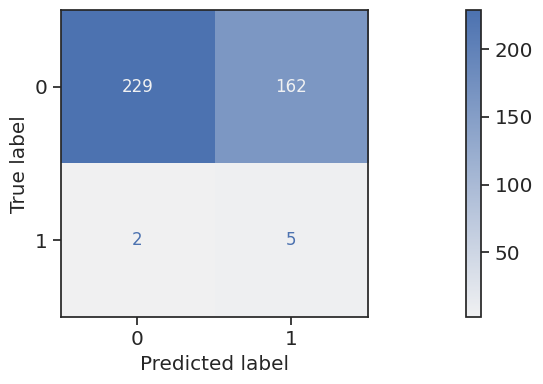

<Figure size 2000x400 with 0 Axes>

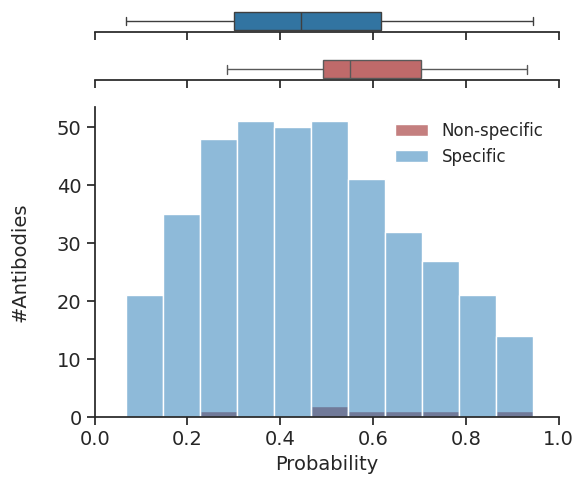

Spearman corr:  0.12163321171260558
P-value:  0.015183853176932865


<Figure size 2000x400 with 0 Axes>

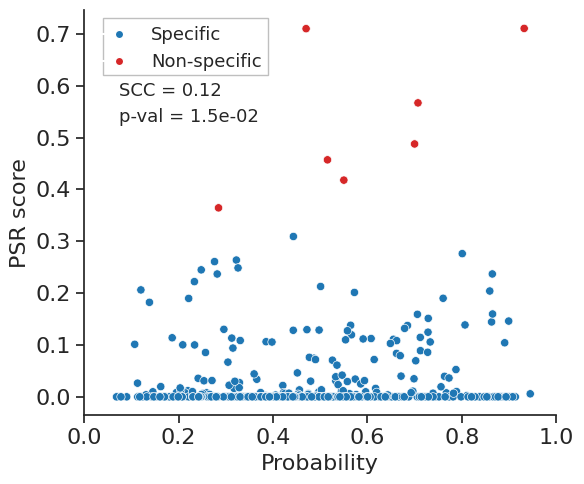

P-value:  0.10769


In [22]:
Ab_type = 'VH'

emb = 'esm1v_VH'

model = 'LogisticReg'

emb_title = 'VH ESM 1v mean'

classifier_dict={"LogisticReg": LogisticRegression(max_iter=500)}

# --- Define Shehata data:
Data_Shehata['class'] = [0 if i<=0.33 else 1 for i in list(Data_Shehata['PSR Score']) ]

# --- Classify:

# Define training/test data:
X=sub_Data_Boughter_2classes[emb].values
X_train=np.array([list(i) for i in X])
y_train=sub_Data_Boughter_2classes['class'].values

X_test = Data_Shehata[emb].values
X_test = np.array([list(i) for i in X_test])
y_test = Data_Shehata['class'].values


# Classify based on parsed dataset:    
clf=classifier_dict[model]
clf.fit(X_train, y_train)
score_OneSplit = clf.score(X_test, y_test)

print('ML algorithms: ' + str(model))
print('Accuracy: ', score_OneSplit)

conf_mat = confusion_matrix(y_test, clf.predict(X_test),labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=clf.classes_)
disp.plot(cmap=sns.color_palette("light:b", as_cmap=True),values_format='g')
#plt.title(str(model) + ' ' + str(emb_title[i]))
plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_conf_mat'+str(model)+'_'+str(emb) +'.pdf',dpi=300)

plt.show()


# --- Distriubution plot of probability (2 classes):
plt.figure(2)
sns.set(style='ticks') # Make white lines between bars.

# Create a subplot with row=3 and col=1, specify height ratio, and define handles for order of the plots (e.g. ax_box1,ax_box2, ax_hist):
f, (ax_box1,ax_box2, ax_hist) = plt.subplots(3,1,figsize=(6,5),sharex=True, gridspec_kw={'height_ratios': (0.06,0.06, 0.85)})

# Define df:    
df_boxplot2 = pd.DataFrame({'prob':clf.predict_proba(X_test)[:,1], 
                            'class': y_test})


# Define data:
data1 = df_boxplot2[df_boxplot2['class']==0]['prob']
data2 = df_boxplot2[df_boxplot2['class']==1]['prob']

# Create the plots for the respective axes (ax_box1,ax_box2, ax_hist):
sns.boxplot(data1, 
            ax=ax_box1,
            color='tab:blue',
            #saturation=0.75,
            orient="h",
            fliersize=3)
sns.boxplot(data2,
            ax=ax_box2,
            color='indianred',
            #saturation=0.75,
            orient="h",
            fliersize=3)
g=sns.histplot(data=df_boxplot2,
               x='prob',
               hue='class',
               palette=['tab:blue','darkred'],
               #bins=8,
               ax=ax_hist,
               #kde=True,
               legend=False
               )

g.set(xlim=(0,1))
plt.legend(labels=['Non-specific','Specific'],
           loc='upper right',
           prop={'size':12},
           #bbox_to_anchor=(1.5, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )

plt.xlabel('Probability',fontsize=14)
plt.ylabel('#Antibodies',fontsize=14,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=14)


# Remove black lines and yticks of the boxplots:
ax_box1.set(yticks=[],xlabel='')
ax_box2.set(yticks=[],xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box1,left=True, right=True)
sns.despine(ax=ax_box2,left=True, right=True)   

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Shehata_dist_prob_2classes_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
plt.show()




# --- Regression-like boxplots (all flags):
# Set fonts globally:
import matplotlib.pylab as pylab

params = {'legend.title_fontsize': 'medium',
          'legend.fontsize': 'medium',
          'figure.figsize': (20, 4),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create an array with the colors:
colors = ['tab:blue','steelblue','lightsteelblue','whitesmoke','salmon','indianred','tab:red','firebrick']

# Plot:
# Define df:    
df_boxplot3 = pd.DataFrame({'prob': clf.predict_proba(X_test)[:,1],
                            'Pred class': clf.predict(X_test),
                            'True class': y_test, 
                            'PSR': Data_Shehata['PSR Score']
                            })

# --- Spearman correlation:
from scipy import stats

corr, pval = stats.spearmanr(list(df_boxplot3['PSR']),list(df_boxplot3['prob']))
#corr, pval = stats.kendalltau(list(df_boxplot3['PSR']),list(df_boxplot3['prob']))
print('Spearman corr: ', corr)
print('P-value: ', pval)

plt.figure(3)
fig, ax = plt.subplots()
s = sns.scatterplot(data=df_boxplot3,
                    x="prob", 
                    y='PSR',
                    hue='True class',
                    palette=['tab:blue','tab:red'],
                    legend=False,
                    )

plt.xlim(0,1)


legend_elements = [Line2D([0],[0],marker='o',color='w',markerfacecolor='tab:blue',label='Specific'), 
                   Line2D([0],[0],marker='o',color='w',markerfacecolor='tab:red',label='Non-specific'),
                   ]

rectangle = Rectangle((0.04,0.62),0.35,0.11,linewidth=1,edgecolor='grey',facecolor='w',alpha=0.5)

plt.legend(handles=legend_elements,
           prop={'size':13},
           loc='upper left',
           #bbox_to_anchor=(1.15, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )

plt.text(0.074,0.58, #0.75,0.7
          'SCC = ' + str(round(corr,2)), 
          fontsize=13,
          )
plt.text(0.074,0.53,#0.75,0.66
          'p-val = '+ str('{:.1e}'.format(pval)), 
          fontsize=13,
          )

ax.add_patch(rectangle)

plt.ylabel('PSR score', fontsize=16)
plt.xlabel('Probability', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

fig_handle = plt.gcf()
fig_handle.set_size_inches(6,5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Shehata_scatter_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
    
plt.show()


# t-test:
'''
H0: Samples come from populations with the same population mean
H1: Samples come from population with different population mean
P-value is the probability that the H0 hypothesis is true.
'''
from scipy import stats
t_test_result = stats.ttest_ind(list(data1),list(data2))

pval = '{:.5}'.format(t_test_result.pvalue)
print('P-value: ', pval)


### Top 5 descriptors VH-based LogisticReg model:

ML algorithms: LogisticReg
Accuracy:  0.5


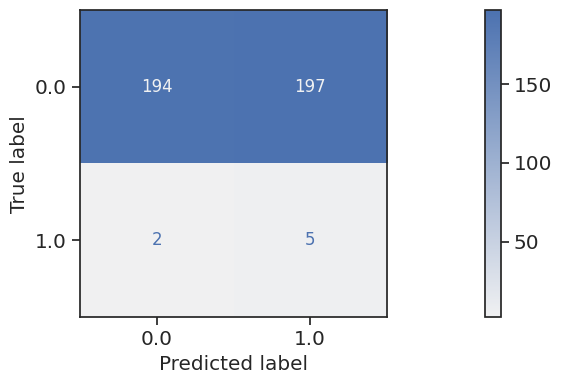

<Figure size 2000x400 with 0 Axes>

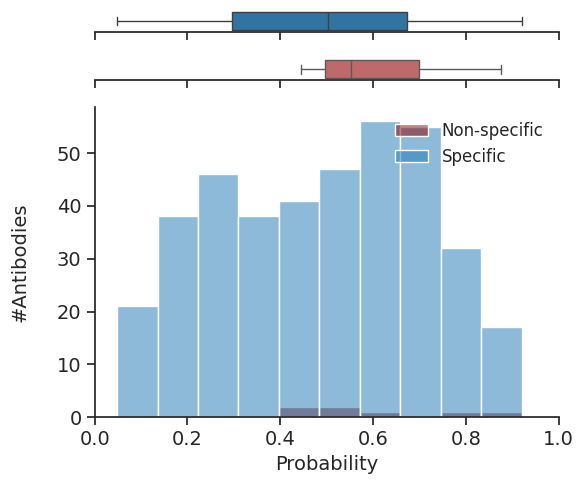

Spearman corr:  0.16215888671655293
P-value:  0.0011687593293920756


<Figure size 2000x400 with 0 Axes>

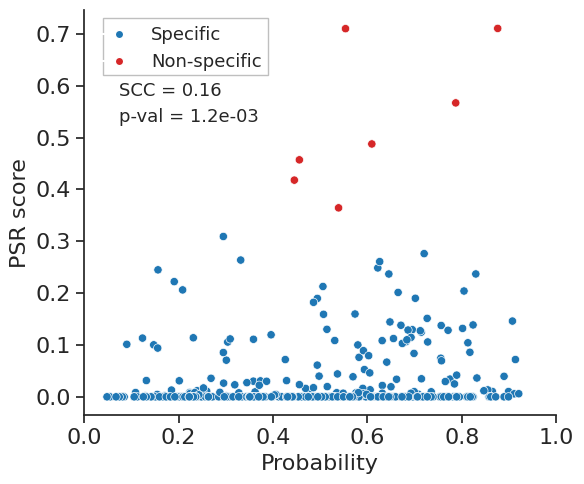

P-value:  0.15035


In [23]:
Ab_type = 'VH'

model = 'LogisticReg'

emb_title = ['Top 5 descriptors VH']

classifier_dict={"LogisticReg": LogisticRegression(max_iter=500)}


# --- Define Shehata data:
Data_desc_Shehata_full = dict_desc_Shehata[Ab_type]
Data_desc_Shehata_full['class'] = [0 if i<=0.33 else 1 for i in list(Data_desc_Shehata_full['PSR Score']) ]

    
# --- Classify:
desc_top5 = ['Theoretical pI', 
             'Bulkiness', 
             'Disorder_Propensity_DisProt', 
             'Percentage_Accessible_Res', 
             'Aggrescan_av4']

desc_input = desc_top5

    
# Define training/test data:
sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
X = np.array([np.array(sub_data_2classes[desc_input])[i,:] for i in range(len(sub_data_2classes[desc_input]))]) 
scaler = StandardScaler().fit(X) # Normalize X.
X_train = scaler.transform(X) # Normalize X.
y_train=sub_data_2classes['class'].values

X_test = np.array([np.array(Data_desc_Shehata_full[desc_input])[i,:] for i in range(len(Data_desc_Shehata_full[desc_input]))]) 
scaler = StandardScaler().fit(X_test) # Normalize X.
X_test = scaler.transform(X_test) # Normalize X.
y_test =Data_desc_Shehata_full['class'].values

# Classify based on parsed dataset:    
clf=classifier_dict[model]
clf.fit(X_train, y_train)
score_OneSplit = clf.score(X_test, y_test)

print('ML algorithms: ' + str(model))
print('Accuracy: ', score_OneSplit)

conf_mat = confusion_matrix(y_test, clf.predict(X_test),labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=clf.classes_)
disp.plot(cmap=sns.color_palette("light:b", as_cmap=True),values_format='g')
#plt.title(str(model) + ' ' + str(emb_title[i]))
plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Jain_conf_mat'+str(model)+'_'+str(emb) +'.pdf',dpi=300)

plt.show()


# --- Distriubution plot of probability (2 classes):
plt.figure(2)
sns.set(style='ticks') # Make white lines between bars.

# Create a subplot with row=3 and col=1, specify height ratio, and define handles for order of the plots (e.g. ax_box1,ax_box2, ax_hist):
f, (ax_box1,ax_box2, ax_hist) = plt.subplots(3,1,figsize=(6,5),sharex=True, gridspec_kw={'height_ratios': (0.06,0.06, 0.85)})

# Define df:    
df_boxplot2 = pd.DataFrame({'prob':clf.predict_proba(X_test)[:,1], 
                            'class': y_test})


# Define data:
data1 = df_boxplot2[df_boxplot2['class']==0]['prob']
data2 = df_boxplot2[df_boxplot2['class']==1]['prob']

# Create the plots for the respective axes (ax_box1,ax_box2, ax_hist):
sns.boxplot(data1, 
            ax=ax_box1,
            color='tab:blue',
            #saturation=0.75,
            orient="h",
            fliersize=3)
sns.boxplot(data2,
            ax=ax_box2,
            color='indianred',
            #saturation=0.75,
            orient="h",
            fliersize=3)
g=sns.histplot(data=df_boxplot2,
               x='prob',
               hue='class',
               palette=['tab:blue','darkred'],
               #bins=8,
               ax=ax_hist,
               #kde=True,
               legend=False
               )

g.set(xlim=(0,1))
plt.legend(labels=['Non-specific','Specific'],
           loc='upper right',
           prop={'size':12},
           #bbox_to_anchor=(1.5, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )

plt.xlabel('Probability',fontsize=14)
plt.ylabel('#Antibodies',fontsize=14,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=14)


# Remove black lines and yticks of the boxplots:
ax_box1.set(yticks=[],xlabel='')
ax_box2.set(yticks=[],xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box1,left=True, right=True)
sns.despine(ax=ax_box2,left=True, right=True)   

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Shehata_dist_prob_2classes_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
plt.show()




# --- Regression-like boxplots (all flags):
# Set fonts globally:
import matplotlib.pylab as pylab

params = {'legend.title_fontsize': 'medium',
          'legend.fontsize': 'medium',
          'figure.figsize': (20, 4),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create an array with the colors:
colors = ['tab:blue','steelblue','lightsteelblue','whitesmoke','salmon','indianred','tab:red','firebrick']

# Plot:
# Define df:    
df_boxplot3 = pd.DataFrame({'prob': clf.predict_proba(X_test)[:,1],
                            'Pred class': clf.predict(X_test),
                            'True class': y_test, 
                            'PSR': Data_Shehata['PSR Score']
                            })

# --- Spearman correlation:
from scipy import stats

corr, pval = stats.spearmanr(list(df_boxplot3['PSR']),list(df_boxplot3['prob']))
#corr, pval = stats.kendalltau(list(df_boxplot3['PSR']),list(df_boxplot3['prob']))
print('Spearman corr: ', corr)
print('P-value: ', pval)

plt.figure(3)
fig, ax = plt.subplots()
s = sns.scatterplot(data=df_boxplot3,
                    x="prob", 
                    y='PSR',
                    hue='True class',
                    palette=['tab:blue','tab:red'],
                    legend=False,
                    )

plt.xlim(0,1)


legend_elements = [Line2D([0],[0],marker='o',color='w',markerfacecolor='tab:blue',label='Specific'), 
                   Line2D([0],[0],marker='o',color='w',markerfacecolor='tab:red',label='Non-specific'),
                   ]

rectangle = Rectangle((0.04,0.62),0.35,0.11,linewidth=1,edgecolor='grey',facecolor='w',alpha=0.5)

plt.legend(handles=legend_elements,
           prop={'size':13},
           loc='upper left',
           #bbox_to_anchor=(1.15, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )

plt.text(0.074,0.58, #0.75,0.7
          'SCC = ' + str(round(corr,2)), 
          fontsize=13,
          )
plt.text(0.074,0.53,#0.75,0.66
          'p-val = '+ str('{:.1e}'.format(pval)), 
          fontsize=13,
          )

ax.add_patch(rectangle)

plt.ylabel('PSR score', fontsize=16)
plt.xlabel('Probability', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

fig_handle = plt.gcf()
fig_handle.set_size_inches(6,5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Shehata_scatter_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
    
plt.show()


# t-test:
'''
H0: Samples come from populations with the same population mean
H1: Samples come from population with different population mean
P-value is the probability that the H0 hypothesis is true.
'''
from scipy import stats
t_test_result = stats.ttest_ind(list(data1),list(data2))

pval = '{:.5}'.format(t_test_result.pvalue)
print('P-value: ', pval)


## Test on Harvery dataset:

### Load Harvey PLM-based data:

In [15]:
# --- Load Harvey dataset and embeddings:
Data_Harvey_labelled = pd.read_excel('./Data/Datasets/Harvey_data.xlsx',index_col=0)

# Open embeddings:
embed_open = pd.read_csv('./Data/Embeddings/esm1v_t33_650M_UR90S_1/Harvey_esm1v_t33_650M_UR90S_1_VH_mean_emb.csv', index_col=0)
                
# Convert to numpy:
embed_open = embed_open.to_numpy()

# Add to Data-df:
Data_Harvey = 
Data_Harvey['esm1v_VH'] = list(embed_open)

# Add class:
Data_Harvey['class'] = [0 if str(i) =='Specific' else 1 if str(i) =='Non-specific' else 1 if str(i)=='Low-throughput NBs' else print(i) for i in list(Data_Harvey['Dataset']) ]


### Load Harvey descriptor-based data:

In [27]:
# --- Load descriptors:
Data_desc_Harvey = pd.read_csv('./Data/Embeddings/Schrödinger_desc/Harvey dataset/sequence_descriptors_sorted.csv')

# Add class:
Data_desc_Harvey['class'] = [0 if str(i) =='Specific' else 1 if str(i) =='Non-specific' else 1 if str(i)=='Low-throughput NBs' else print(i) for i in list(Data_desc_Harvey['Specificty']) ]


### ESM 1v VH-based LogisticReg model:

ML algorithms: LogisticReg
Accuracy:  0.6179684795738879


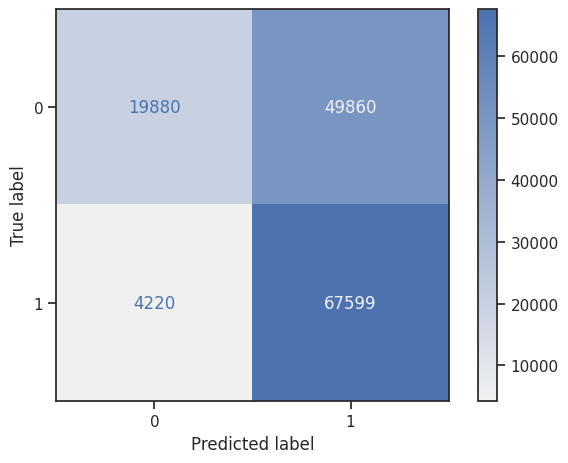

<Figure size 640x480 with 0 Axes>

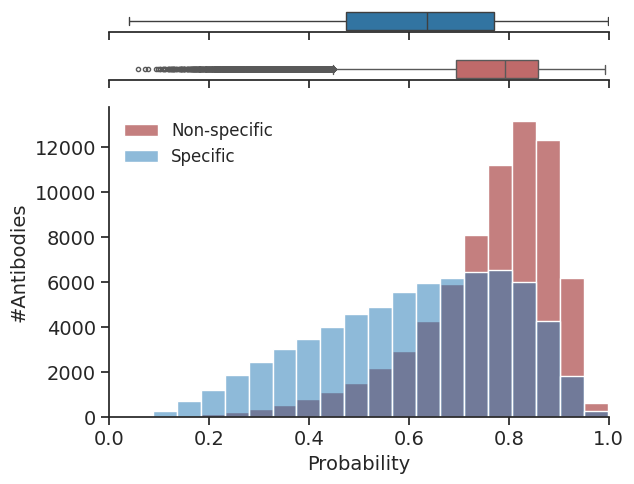

P-value:  0.0


In [14]:
# --- Test Harvey dataset:

emb = 'esm1v_VH'

model = 'LogisticReg'

emb_title = ['VH ESM 1v mean']

classifier_dict={"LogisticReg": LogisticRegression(max_iter=500)}

# Define training/test data:
X=sub_Data_Boughter_2classes[emb].values
X_train=np.array([list(i) for i in X])
y_train=sub_Data_Boughter_2classes['class'].values

X_test = Data_Harvey[emb].values
X_test = np.array([list(i) for i in X_test])
y_test = Data_Harvey['class'].values

X_test_full = Data_Harvey[emb].values
X_test_full = np.array([list(i) for i in X_test_full])
y_test_full = Data_Harvey['class'].values


# Classify based on parsed dataset:    
clf=classifier_dict[model]
clf.fit(X_train, y_train)
score_OneSplit = clf.score(X_test, y_test)

print('ML algorithms: ' + str(model))
print('Accuracy: ', score_OneSplit)


conf_mat = confusion_matrix(y_test, clf.predict(X_test),labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=clf.classes_)
disp.plot(cmap=sns.color_palette("light:b", as_cmap=True),values_format='g')
#plt.title(str(model) + ' ' + str(emb_title[i]))
plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Harvey_conf_mat'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
plt.show()


# Plot:
plt.figure(1)
sns.set(style='ticks') # Make white lines between bars.

# Create a subplot with row=3 and col=1, specify height ratio, and define handles for order of the plots (e.g. ax_box1,ax_box2, ax_hist):
f, (ax_box1,ax_box2, ax_hist) = plt.subplots(3,1,figsize=(6,5),sharex=True, gridspec_kw={'height_ratios': (0.06,0.06, 0.85)})

# Define df:    
df_boxplot2 = pd.DataFrame({'prob':clf.predict_proba(X_test)[:,1], 
                            'class': y_test})



# Define data:
data1 = df_boxplot2[df_boxplot2['class']==0]['prob']
data2 = df_boxplot2[df_boxplot2['class']==1]['prob']


# Create the plots for the respective axes (ax_box1,ax_box2, ax_hist):
sns.boxplot(data1, 
            ax=ax_box1,
            color='tab:blue',
            #saturation=0.75,
            orient="h",
            fliersize=3)
sns.boxplot(data2,
            ax=ax_box2,
            color='indianred',
            #saturation=0.75,
            orient="h",
            fliersize=3)
g=sns.histplot(data=df_boxplot2,
               x='prob',
               hue='class',
               palette=['tab:blue','darkred'],
               bins=20,
               ax=ax_hist,
               #kde=True,
               legend=False
               )

g.set(xlim=(0,1))
plt.legend(labels=['Non-specific','Specific'],
           loc='upper left',
           prop={'size':12},
           #bbox_to_anchor=(1.5, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )

plt.xlabel('Probability',fontsize=14)
plt.ylabel('#Antibodies',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)


# Remove black lines and yticks of the boxplots:
ax_box1.set(yticks=[],xlabel='')
ax_box2.set(yticks=[],xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box1,left=True, right=True)
sns.despine(ax=ax_box2,left=True, right=True)   

fig_handle = plt.gcf()
fig_handle.set_size_inches(6.5,5)

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Harvey_dist_prob_2classes_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
    
plt.show()


# t-test:
'''
H0: Samples come from populations with the same population mean
H1: Samples come from population with different population mean
P-value is the probability that the H0 hypothesis is true.
'''
from scipy import stats
t_test_result = stats.ttest_ind(data1.values,data2.values)

pval = '{:.5}'.format(t_test_result.pvalue)
print('P-value: ', pval)


### Top 5 descriptors VH-based LogisticReg model:

In [ ]:
# --- Test Harvey dataset:

model = 'LogisticReg'

emb_title = ['VH ESM 1v mean']

classifier_dict={"LogisticReg": LogisticRegression(max_iter=500)}

# --- Classify:
desc_top5 = ['Theoretical pI', 
             'Bulkiness', 
             'Disorder_Propensity_DisProt', 
             'Percentage_Accessible_Res', 
             'Aggrescan_av4']

desc_input = desc_top5

    
# Define training/test data:
sub_data_2classes = dict_desc_Boughter_2classes[Ab_type]
X = np.array([np.array(sub_data_2classes[desc_input])[i,:] for i in range(len(sub_data_2classes[desc_input]))]) 
scaler = StandardScaler().fit(X) # Normalize X.
X_train = scaler.transform(X) # Normalize X.
y_train=sub_data_2classes['class'].values

X_test = np.array([np.array(Data_desc_Harvey[desc_input])[i,:] for i in range(len(Data_desc_Harvey[desc_input]))]) 
scaler = StandardScaler().fit(X_test) # Normalize X.
X_test = scaler.transform(X_test) # Normalize X.
y_test =Data_desc_Harvey['class'].values


# Classify based on parsed dataset:    
clf=classifier_dict[model]
clf.fit(X_train, y_train)
score_OneSplit = clf.score(X_test, y_test)

print('ML algorithms: ' + str(model))
print('Accuracy: ', score_OneSplit)


conf_mat = confusion_matrix(y_test, clf.predict(X_test),labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=clf.classes_)
disp.plot(cmap=sns.color_palette("light:b", as_cmap=True),values_format='g')
#plt.title(str(model) + ' ' + str(emb_title[i]))
plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Harvey_conf_mat'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
plt.show()


# Plot:
plt.figure(1)
sns.set(style='ticks') # Make white lines between bars.

# Create a subplot with row=3 and col=1, specify height ratio, and define handles for order of the plots (e.g. ax_box1,ax_box2, ax_hist):
f, (ax_box1,ax_box2, ax_hist) = plt.subplots(3,1,figsize=(6,5),sharex=True, gridspec_kw={'height_ratios': (0.06,0.06, 0.85)})

# Define df:    
df_boxplot2 = pd.DataFrame({'prob':clf.predict_proba(X_test)[:,1], 
                            'class': y_test})



# Define data:
data1 = df_boxplot2[df_boxplot2['class']==0]['prob']
data2 = df_boxplot2[df_boxplot2['class']==1]['prob']


# Create the plots for the respective axes (ax_box1,ax_box2, ax_hist):
sns.boxplot(data1, 
            ax=ax_box1,
            color='tab:blue',
            #saturation=0.75,
            orient="h",
            fliersize=3)
sns.boxplot(data2,
            ax=ax_box2,
            color='indianred',
            #saturation=0.75,
            orient="h",
            fliersize=3)
g=sns.histplot(data=df_boxplot2,
               x='prob',
               hue='class',
               palette=['tab:blue','darkred'],
               bins=20,
               ax=ax_hist,
               #kde=True,
               legend=False
               )

g.set(xlim=(0,1))
plt.legend(labels=['Non-specific','Specific'],
           loc='upper left',
           prop={'size':12},
           #bbox_to_anchor=(1.5, 0.85), 
           ncol=1,
           frameon=False,
           borderaxespad=0.5,
           )

plt.xlabel('Probability',fontsize=14)
plt.ylabel('#Antibodies',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)


# Remove black lines and yticks of the boxplots:
ax_box1.set(yticks=[],xlabel='')
ax_box2.set(yticks=[],xlabel='')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box1,left=True, right=True)
sns.despine(ax=ax_box2,left=True, right=True)   

fig_handle = plt.gcf()
fig_handle.set_size_inches(6.5,5)

plt.tight_layout()
#plt.savefig('./Figures_publication/Validation_external/Harvey_dist_prob_2classes_'+str(model)+'_'+str(emb) +'.pdf',dpi=300)
    
plt.show()


# t-test:
'''
H0: Samples come from populations with the same population mean
H1: Samples come from population with different population mean
P-value is the probability that the H0 hypothesis is true.
'''
from scipy import stats
t_test_result = stats.ttest_ind(data1.values,data2.values)

pval = '{:.5}'.format(t_test_result.pvalue)
print('P-value: ', pval)
